In [8]:
import os
import sys
import gzip
import code
import urllib
import importlib
import tensorflow.python.platform
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm
from PIL import Image

In [9]:
COLAB = True
BRANCH = 'tuantu'

In [10]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/Shareddrives/ML_Road_Segmentation/CS-433-project-tuantu/project_road_segmentation'
    os.chdir(drive_path)
    from helpers.colab import mount_and_pull
    BRANCH_NAME = BRANCH
    # mount_and_pull(BRANCH_NAME, drive, os)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%load_ext autoreload
%autoreload 2

from helpers.image_processing import *
from helpers.file_manipulation import *
from helpers.constants import *
from helpers.prediction_checking import *
from helpers.machine_learning import *
from helpers.loss_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
RESTORE_MODEL = False  # If True, restore existing model instead of training a new one
SAVE_MODEL = True
GENERATE_PREDICTION = False  # If True, will generate a CSV to submit on AICrowd

MODEL_NAME = 'unet_2'  # For now, cnn, unet-1, unet-2
SAVE_DIR = MODELS_SAVE_DIR + MODEL_NAME + '/'

NUM_EPOCHS = 250

In [13]:
mod = importlib.import_module('models.' + MODEL_NAME)
model_function = getattr(mod, MODEL_NAME)

In [16]:
X_train, X_test, y_train, y_test = get_train_test(data_augmentation=True, transformations =['hard_raw', 'mix', 'flip','shift', 'rotation'])

Loading data/training/groundtruth/: 100%|██████████| 100/100 [00:00<00:00, 338.77it/s]


Training features shape :  (100, 400, 400, 3)
Training labels shape :  (100, 400, 400)


In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generator(images, masks, data_gen_args, batch_size=80, seed=SEED):
    """
    :param data_gen_args: augmentation arguments for the ImageDataGenerator
    :param folder: DO NOT INCLUDE ENDING SLASH "/", name of the folder where the images will be generated 
    :param seed: can be set to None
    """
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    # Provide the same seed and keyword arguments to the fit and flow methods
    # image_datagen.fit(images, augment=True, seed=seed)
    # mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks[:,:,:,np.newaxis], batch_size=batch_size, seed=seed)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [62]:
# List of interesting transformations: rotation_range, vertical/horizontal_flip, width/height_shift_range
data_gen_args = dict(fill_mode='reflect',
                 rotation_range=45,
                 horizontal_flip=True,
                 vertical_flip=True,
                 width_shift_range=0.5,
                 height_shift_range=0.5,
                #  validation_split=VALIDATION_SIZE
                 )

train_generator = get_generator(X_train, y_train, data_gen_args, batch_size=16)

In [63]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape, y_batch.shape)
    break;

(16, 400, 400, 3) (16, 400, 400, 1)


In [ ]:

metrics=[tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
         dice_coef
        ]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5)
            ]
if RESTORE_MODEL:
    model = tf.keras.models.load_model(SAVE_DIR, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
else:  
    model = model_function()
    model.compile(optimizer='adam',
                loss=focal_tversky_loss,
                metrics=metrics)
    history = model.fit(train_generator, 
                        epochs = NUM_EPOCHS,
                        steps_per_epoch=10,
                        validation_data= (X_test, y_test),
                        callbacks=callbacks)

Epoch 1/250
 5/10 [==============>...............] - ETA: 3s - loss: 0.7150 - precision_18: 0.2288 - recall_18: 0.8856 - dice_coef: 0.3230

In [10]:
if SAVE_MODEL:
    model.save(SAVE_DIR)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_save/unet_2/assets


In [11]:
train_predictions = model.predict(X_train).squeeze()
test_predictions = model.predict(X_test).squeeze()

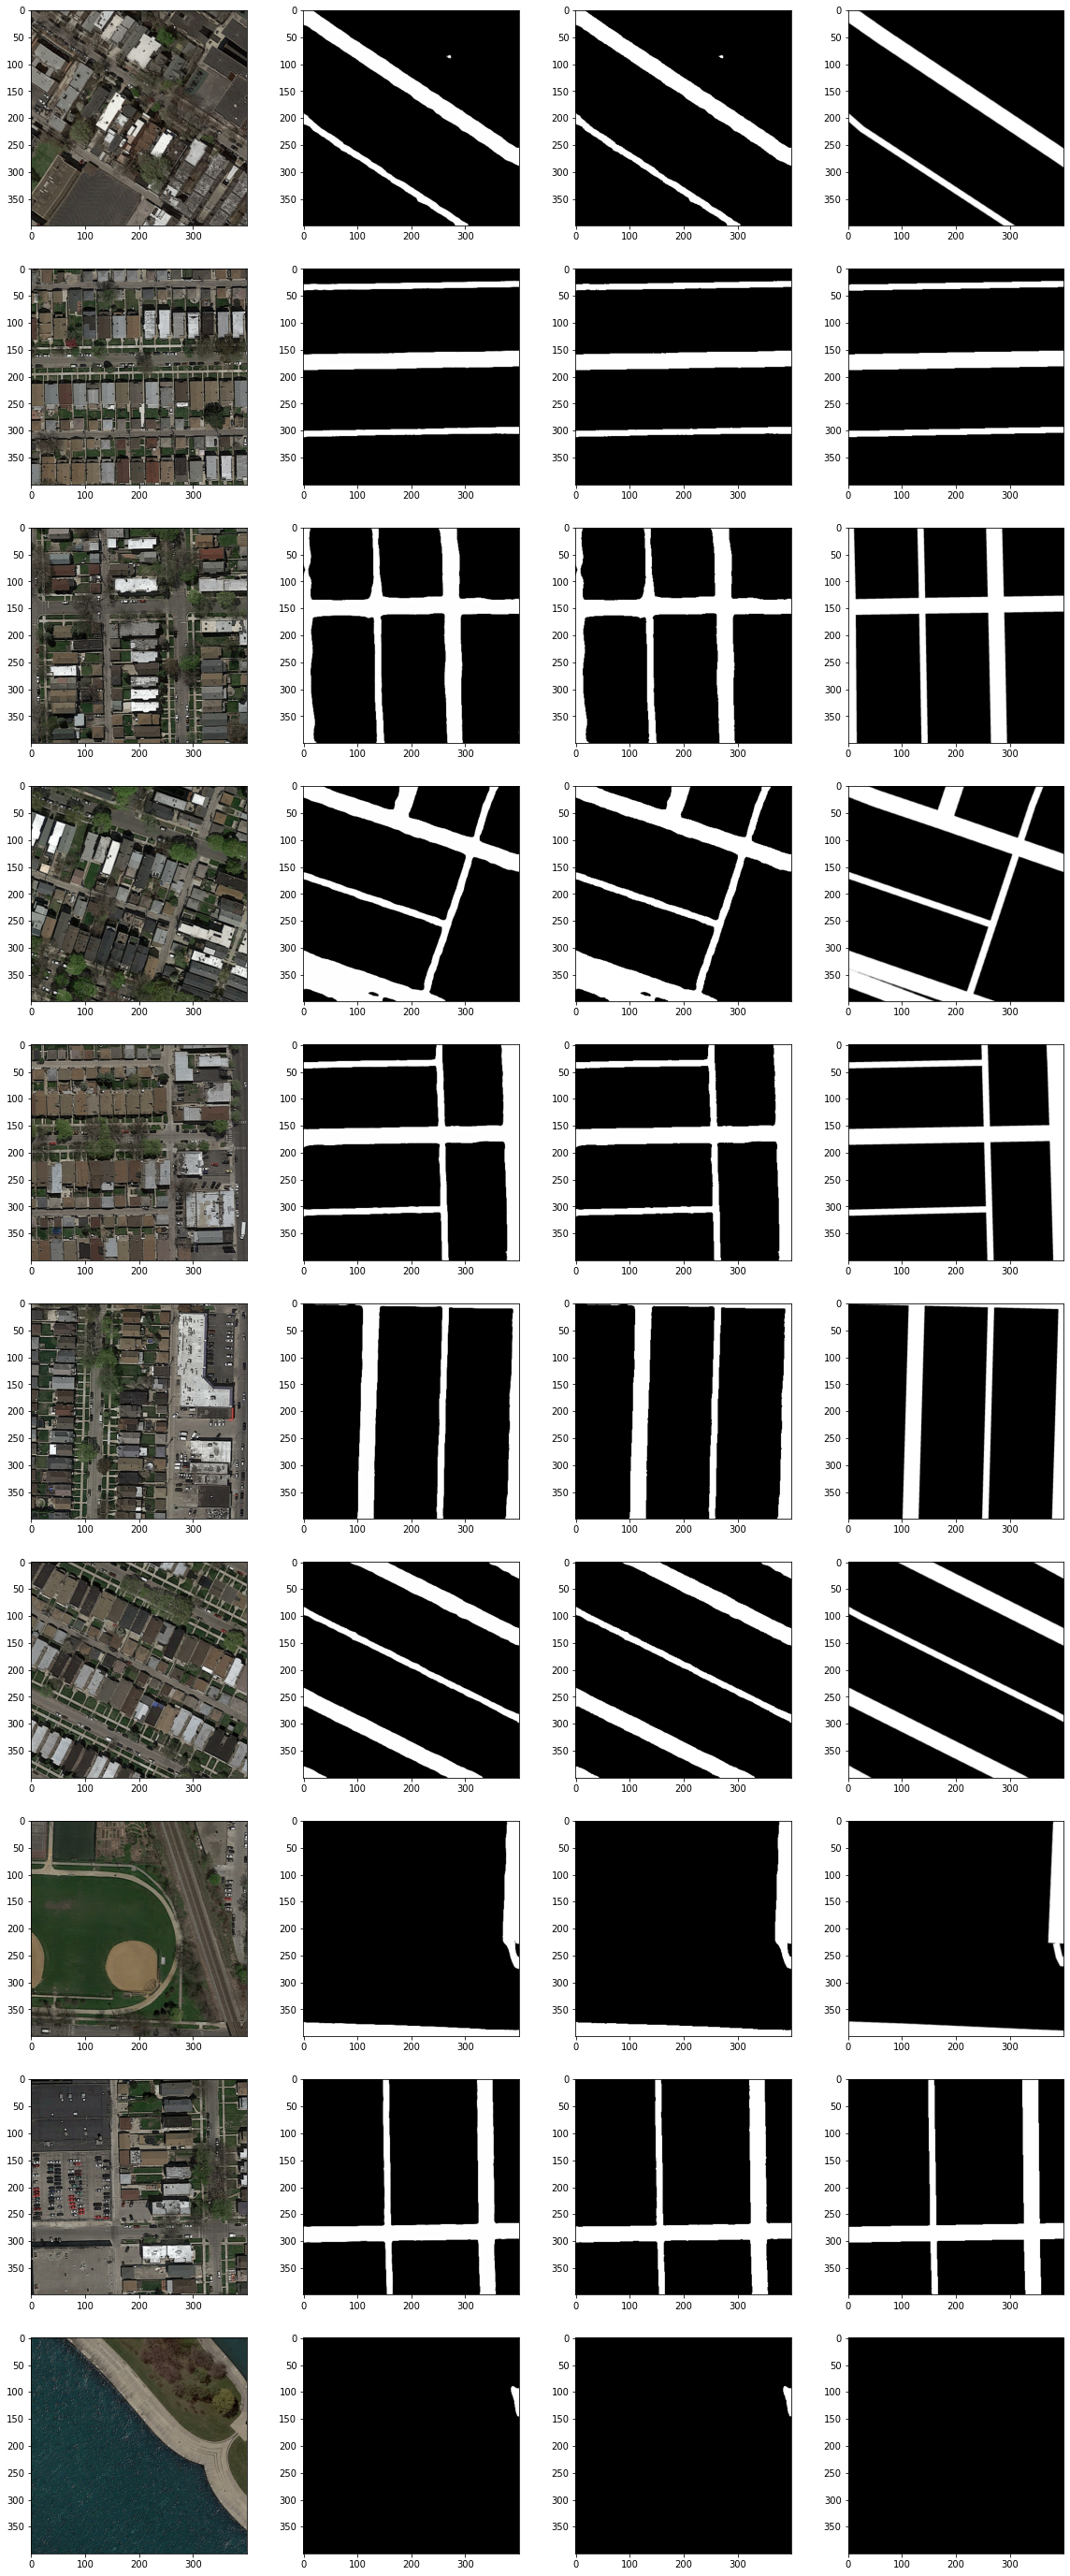

In [12]:
visualize_random_predictions(X_train, y_train, train_predictions, size=10)

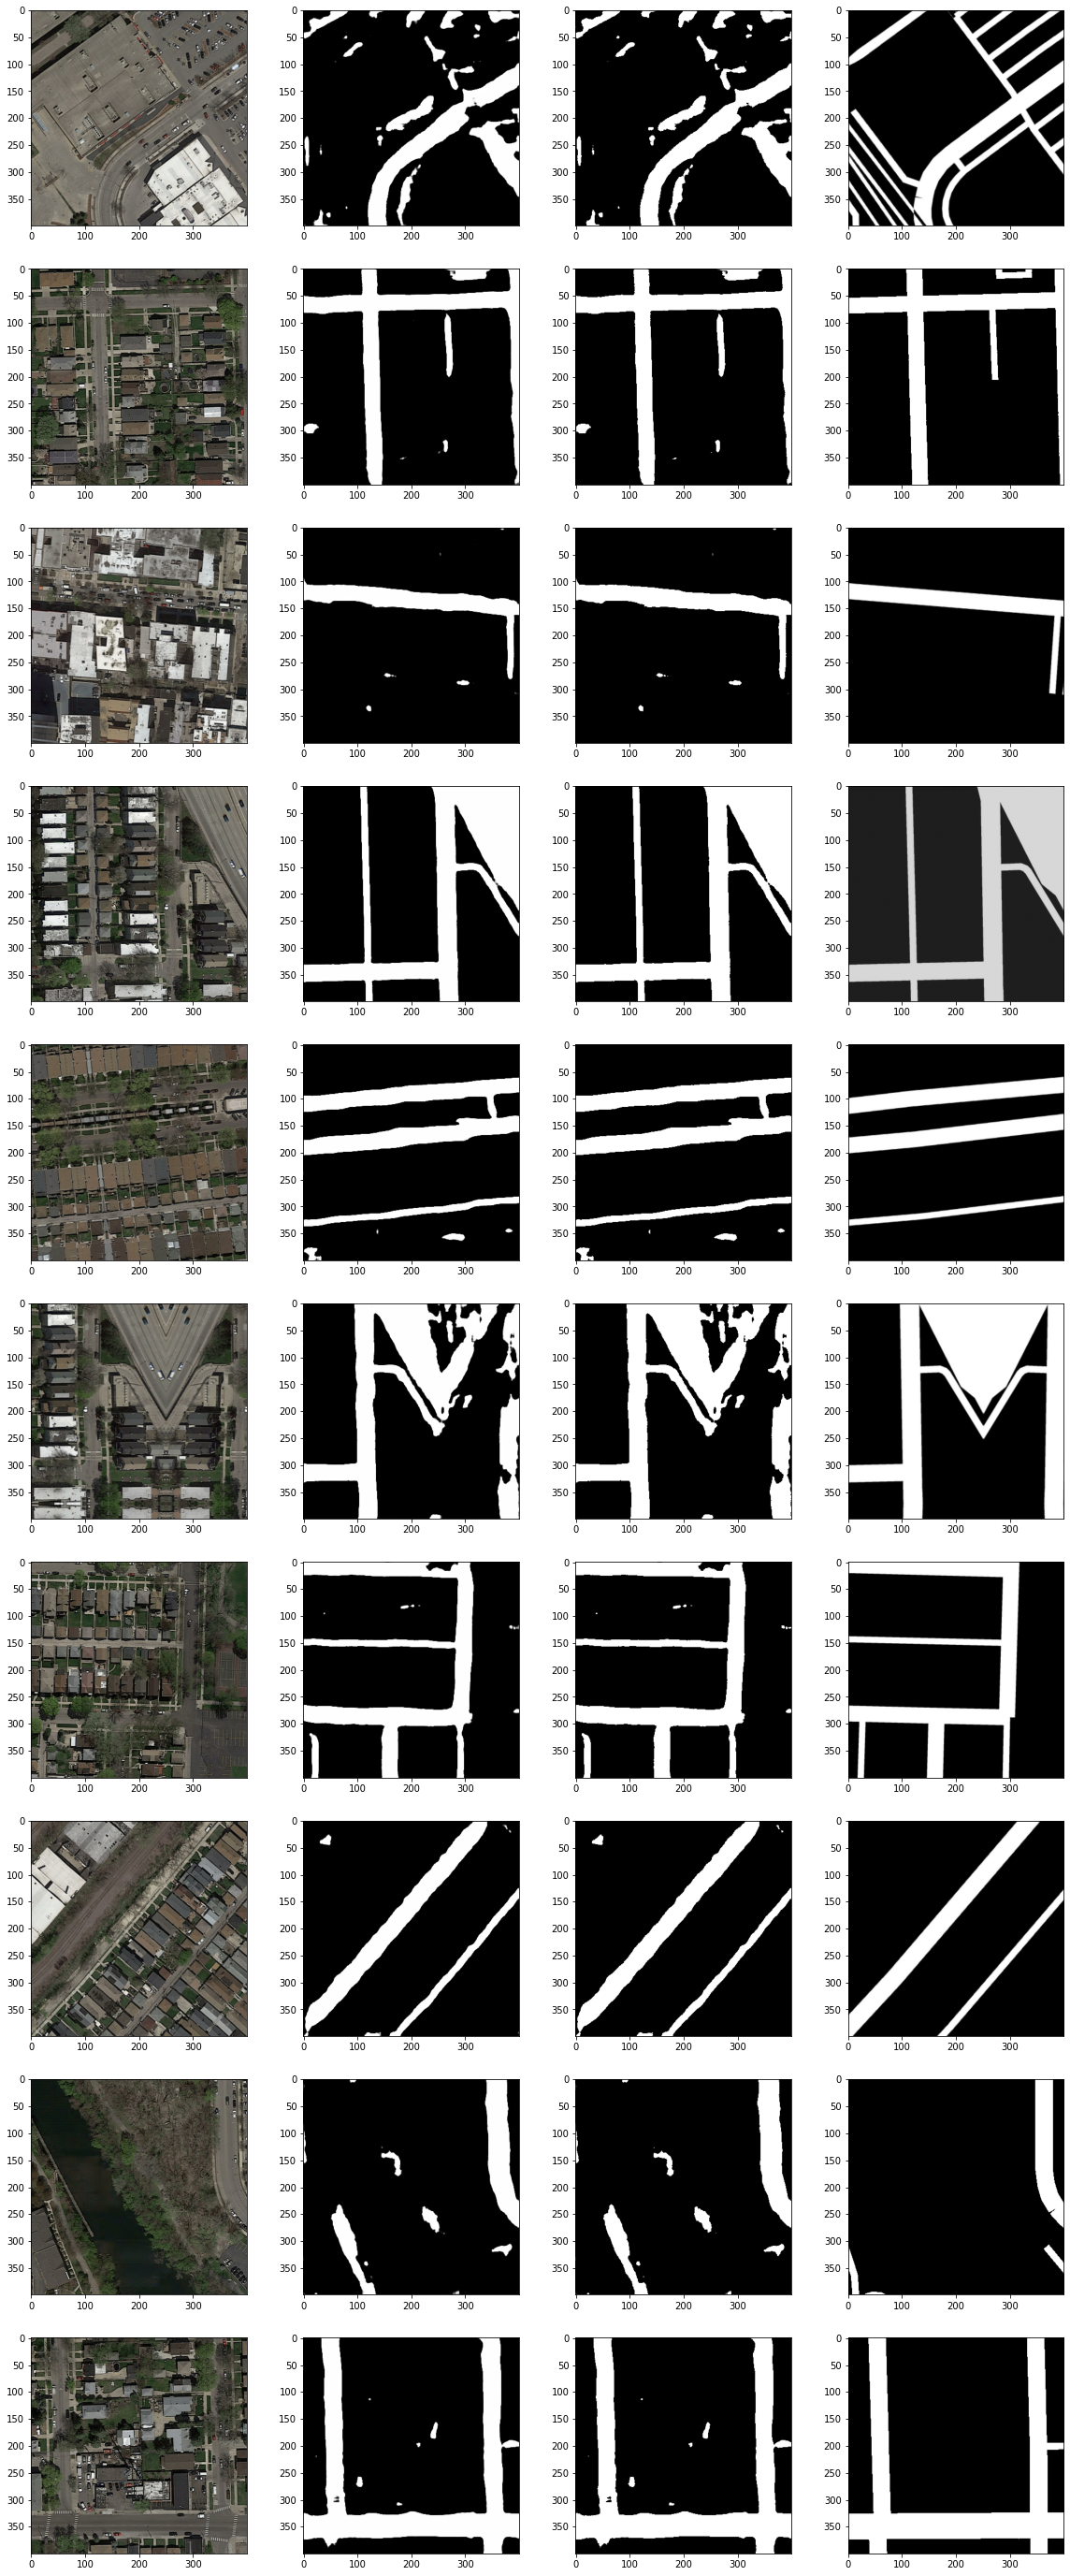

In [13]:
visualize_random_predictions(X_test, y_test, test_predictions, size=10)

In [14]:
hard_data = compute_entire_images_metrics(y_test, test_predictions)

In [15]:
hard_data

f1      acc  precision    recall
metrics  0.802942  0.93026   0.713474  0.918065

In [16]:
from helpers.submission import *

In [17]:
predict_submissions(model)

Loading data/test_set_images/: 100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


Predicting test images...
Creating submission csv at location submissions/submission_12-07-2020_19-44-37.csv
Writing predictions in folder data/predictions/


In [ ]:
if COLAB:
    from helpers.colab import download_model
    from google.colab import files
    download_model(MODEL_NAME, SAVE_DIR, files)